In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt


In [2]:
# SET VALIDATE = TRUE TO COMPUTE VALIDATION. 
# AND SET VALIDATE = FALSE TO MAKE AN SUBMISSION TO LB
VALIDATE = False

# USE 1 TO VALIDATE WITH LAST MONTH OF TRAIN, 2 FOR SECOND TO LAST ETC ETC
# NEW TRAIN DATA IS EVERYTHING BEFORE THIS
VAL_MONTH = 0

# LOAD TRAIN DATA
train = pd.read_csv('new_train.csv')
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"])
train = train.sort_values(['cfips','first_day_of_month']).reset_index(drop=True).drop(['Unnamed: 0'],axis=1)

# DEFINE VALIDATION AND TRAIN MONTHS
trn_months = train.first_day_of_month.values[-39:]
val_months = train.first_day_of_month.values[-1*VAL_MONTH:]
if VAL_MONTH!=1: 
    val_months = train.first_day_of_month.values[-1*VAL_MONTH:-1*VAL_MONTH+1]

# CREATE NEW TRAIN AND NEW TEST DATA IF WE ARE VALIDATING
if VALIDATE:
    test = train.loc[train.first_day_of_month.isin(val_months)]
    train = train.loc[train.first_day_of_month.isin(trn_months)]
print( train.shape )
train.head()

(153615, 27)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,neighbours,lat,...,non_inst_pop,total_pop,pct_non_inst_pop,employed,pct_employed,unemployed,pct_unemployed,year,tax_rate,tax_rate_diff
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,"[1021, 1047, 1051, 1085, 1101]",32.532237,...,3938622.0,2271806.0,57.7,2206223.0,56.0,65583.0,2.9,2019,6.03,0.89
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,"[1021, 1047, 1051, 1085, 1101]",32.532237,...,3941513.0,2273771.0,57.7,2207294.0,56.0,66477.0,2.9,2019,6.03,0.89
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,"[1021, 1047, 1051, 1085, 1101]",32.532237,...,3944209.0,2275680.0,57.7,2207568.0,56.0,68112.0,3.0,2019,6.03,0.89
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,"[1021, 1047, 1051, 1085, 1101]",32.532237,...,3946542.0,2276674.0,57.7,2206498.0,55.9,70176.0,3.1,2019,6.03,0.89
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,"[1021, 1047, 1051, 1085, 1101]",32.532237,...,3948677.0,2275425.0,57.6,2202912.0,55.8,72513.0,3.2,2019,6.03,0.89


In [3]:
train = train.set_index('row_id')


In [4]:
train = train.dropna()

In [5]:
train['target'] = train.groupby('cfips')['microbusiness_density'].shift(-1)
train['target'] = train['target']/train['microbusiness_density'] - 1


#train.loc[train['cfips']==28055, 'target'] = 0.0
#train.loc[train['cfips']==48269, 'target'] = 0.0

In [6]:
train['population']  = 100*train['active']/train['microbusiness_density']
train['population'] = train.groupby('cfips')['population'].ffill()  #forward fill
train['population'] = train['population'].round(0).astype(int)

In [7]:
test = pd.read_csv('test.csv')

test["first_day_of_month"] = pd.to_datetime(test["first_day_of_month"])

test = test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)
test = test.sort_index()
print(test.shape)
test

(25080, 3)


,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01
...,...,...,...
25075,56045_2023-02-01,56045,2023-02-01
25076,56045_2023-03-01,56045,2023-03-01
25077,56045_2023-04-01,56045,2023-04-01
25078,56045_2023-05-01,56045,2023-05-01


In [8]:
train_feat = train.drop(['county','state','istest','first_day_of_month'],axis=1).columns

In [9]:
V1 = pd.read_csv('unemployment_rate_raw.csv')



In [10]:
V1 = V1.T

In [11]:
V1.columns = V1.iloc[0]


In [12]:
#unemployment rate forecast #https://tradingeconomics.com/united-states/unemployment-rate?embed/forecast

In [13]:
V1.loc[len(V1.index)] = V1.iloc[-1] * 3.4 / 3.5 # Jan value is 3.4

In [14]:
#V1.loc[len(V1.index)] = V1.iloc[-1] * 3.6 / 3.4 # I guess Feb value is 3.6

In [15]:
V1 = V1[-42:]

In [16]:
V2 = pd.read_csv('weekly_earnings_raw.csv')
V2 = V2.T
V2.columns = V2.iloc[0]
#https://www.bls.gov/news.release/realer.htm increased 0.7 % in Jan
V2.loc[len(V2.index)] = V2.iloc[-1] * (1.0007) # Jan value is 3.4
V2 = V2[-42:]

In [17]:
V2

Geography,United States,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2019-08-01,1115.114447,984.159963,1199.078019,1069.800956,909.300735,1291.926136,1170.758534,1273.763721,1025.436076,1848.725628,...,918.47449,987.83872,1084.145794,1098.074168,1007.308366,1157.825043,1352.000927,971.932146,1010.454976,1085.568709
2019-09-01,1138.41212,1002.543389,1197.919711,1095.758077,926.72554,1329.442122,1213.663561,1323.465932,1067.31049,1930.031847,...,945.590417,1006.970625,1107.016895,1124.170987,1032.736441,1195.931501,1385.724651,993.885428,1030.447687,1110.137923
2019-10-01,1115.148303,999.057181,1191.888849,1075.613198,904.844149,1292.756418,1165.455225,1297.23122,1035.201585,1836.975362,...,923.850524,984.491009,1085.600771,1104.111227,1019.758906,1157.670454,1347.653472,973.603862,1023.403332,1078.415716
2019-11-01,1115.25043,996.766106,1168.365286,1077.101893,906.875876,1295.607849,1174.584905,1304.239157,1037.810977,1843.995948,...,935.31996,990.673418,1089.194956,1105.130567,1024.806319,1153.133565,1351.953676,983.853761,1022.81004,1083.309973
2019-12-01,1142.610817,1020.530595,1207.647121,1094.425511,929.160999,1337.430985,1210.176503,1331.586842,1059.591646,1963.724467,...,956.31432,1012.711455,1124.443155,1129.779112,1027.645204,1166.680371,1382.902114,986.08942,1035.25645,1101.320676
2020-01-01,1113.896211,1003.815865,1174.125163,1075.66492,910.498381,1297.516855,1166.715909,1286.920702,1042.564883,1880.224774,...,925.834616,988.974347,1090.506439,1064.919201,1021.763747,1136.4116,1322.45981,968.782979,1017.288282,1051.320228
2020-02-01,1137.103406,1012.500022,1207.356308,1110.1519,929.040996,1347.288433,1195.091021,1306.522703,1041.631513,1998.461588,...,946.457933,1002.816296,1118.940684,1114.397135,1023.572054,1154.187608,1382.856618,976.495839,1029.653066,1076.534229
2020-03-01,1140.216079,1015.524888,1223.14423,1086.816421,919.821755,1332.806705,1190.948053,1301.61091,1045.237359,1989.919161,...,949.706705,990.411871,1118.886112,1118.138701,1012.029303,1146.724306,1361.714272,981.063481,1023.734913,1065.601441
2020-04-01,1188.570179,1042.283728,1267.078901,1119.449629,943.806334,1367.70944,1213.215574,1380.419934,1111.994657,2034.593681,...,973.915621,996.743577,1114.934972,1136.859997,1086.816765,1173.069858,1388.569468,1023.634724,1082.614661,1067.010156
2020-05-01,1187.146327,1050.169686,1271.835004,1104.622328,926.320021,1388.611845,1218.43576,1386.597652,1117.101059,2039.496878,...,982.080731,1002.512047,1112.077154,1117.367303,1098.382963,1177.781491,1414.796342,1011.714822,1082.188395,1060.657376


In [18]:

V3 = pd.read_csv('house_price_index_yoy_percent_change.csv')
V3 = V3.T
V3.columns = V3.iloc[0]
V3 = V3[-13:]
V3 = V3.loc[V3.index.repeat(3)][1:]



In [19]:
#house price https://fred.stlouisfed.org/series/ASPUS
house_q4 = V3.iloc[-1] * (535800 / 547800) # Jan value is 3.4
V3.loc[len(V3.index)] =  house_q4
V3.loc[len(V3.index)] =  house_q4
V3.loc[len(V3.index)] =  house_q4
V3.loc[len(V3.index)] =  house_q4 #assume 2023 jan follow q4

In [20]:
V3

Geography,United States,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2019 Q3,4.94818,5.83706,4.240157,7.652474,4.512325,3.880909,5.451149,2.396578,5.169025,6.065173,...,3.66596,6.803932,4.545455,8.250972,6.047917,4.853563,6.275824,3.240024,6.245617,5.731196
2019 Q3,4.94818,5.83706,4.240157,7.652474,4.512325,3.880909,5.451149,2.396578,5.169025,6.065173,...,3.66596,6.803932,4.545455,8.250972,6.047917,4.853563,6.275824,3.240024,6.245617,5.731196
2019 Q4,5.475915,6.495523,3.831809,7.850619,3.802002,4.499964,6.380211,2.090126,7.62624,5.108374,...,4.218172,7.290479,4.960872,8.355136,3.985477,5.359656,7.841838,7.460386,6.529844,6.390644
2019 Q4,5.475915,6.495523,3.831809,7.850619,3.802002,4.499964,6.380211,2.090126,7.62624,5.108374,...,4.218172,7.290479,4.960872,8.355136,3.985477,5.359656,7.841838,7.460386,6.529844,6.390644
2019 Q4,5.475915,6.495523,3.831809,7.850619,3.802002,4.499964,6.380211,2.090126,7.62624,5.108374,...,4.218172,7.290479,4.960872,8.355136,3.985477,5.359656,7.841838,7.460386,6.529844,6.390644
2020 Q1,6.243572,7.082102,2.441736,9.803556,3.395869,6.114391,7.090523,3.633098,8.902182,7.418523,...,3.623595,7.700363,5.279525,9.834149,7.38255,6.960575,8.615619,-0.507775,7.11764,8.989455
2020 Q1,6.243572,7.082102,2.441736,9.803556,3.395869,6.114391,7.090523,3.633098,8.902182,7.418523,...,3.623595,7.700363,5.279525,9.834149,7.38255,6.960575,8.615619,-0.507775,7.11764,8.989455
2020 Q1,6.243572,7.082102,2.441736,9.803556,3.395869,6.114391,7.090523,3.633098,8.902182,7.418523,...,3.623595,7.700363,5.279525,9.834149,7.38255,6.960575,8.615619,-0.507775,7.11764,8.989455
2020 Q2,5.699989,6.796245,3.267405,9.672226,5.07392,4.841707,5.15508,3.807281,4.733756,3.632539,...,4.538066,7.283573,4.604272,8.485814,2.648349,4.58456,8.608202,2.593872,6.052424,4.523026
2020 Q2,5.699989,6.796245,3.267405,9.672226,5.07392,4.841707,5.15508,3.807281,4.733756,3.632539,...,4.538066,7.283573,4.604272,8.485814,2.648349,4.58456,8.608202,2.593872,6.052424,4.523026


In [21]:
V4 = pd.read_csv('state_gdp_yoy_percent_change.csv')
V4 = V4.T
V4.columns = V4.iloc[0]
V4 = V4[-13:]
V4 = V4.loc[V4.index.repeat(3)][1:]

In [22]:
#https://tradingeconomics.com/united-states/gdp-growth-annual

house_q4 = V4.iloc[-1] * (1 / 1.9) # Jan value is 3.4
V4.loc[len(V4.index)] =  house_q4
V4.loc[len(V4.index)] =  house_q4
V4.loc[len(V4.index)] =  house_q4
V4.loc[len(V4.index)] =  house_q4 #assume 2023 jan follow q4

In [23]:

IDS = train.cfips.unique()
#x_train = np.arange(TRAIN_SZ).reshape((-1,1))
#x_test = np.arange(TRAIN_SZ-1,TRAIN_SZ+TEST_SZ).reshape((-1,1))


In [24]:
import numpy as np

import pandas as pd
import copy
import talib._ta_lib as talib
np.seterr(invalid='raise')
def signal(data, col):
    content = [col] #+ ['date']
    df = data[content].copy()
    #print(df)
    c = df[col].values
    col = col + '_'
    ta_list = []
    col_list = []
    ta_list.append( talib.ROC       (c, timeperiod=2) )
    col_list.append('ROC2')
    for p in [3, 6, 12]:
        ps = str(p)
        ta_list.append(talib.EMA       (c, timeperiod=p))
        col_list.append('EMA'+str(p))
        #ta_list.append(talib.SMA       (c, timeperiod=p))
        #col_list.append('SMA'+str(p))
        ta_list.append(talib.MOM       (c, timeperiod=p))
        col_list.append('MOM'+str(p))
        #ta_list.append(talib.EMA       (c, timeperiod=p) /c )
        #col_list.append('EMAc'+str(p))
        #ta_list.append(talib.SMA       (c, timeperiod=p) /c )
        #col_list.append('SMAc'+str(p))
        #ta_list.append(talib.MOM       (c, timeperiod=p) /c )
        #col_list.append('MOMc'+str(p))
        
        ta_list.append(talib.RSI       (c, timeperiod=p))
        col_list.append('RSI'+str(p))
        #data['RSI_H'+ps       ] = talib.RSI       (h, timeperiod=p)
        #data['RSI_L'+ps       ] = talib.RSI       (l, timeperiod=p)
        ta_list.append( talib.ROC       (c, timeperiod=p) )
        col_list.append('ROC'+str(p))
        #df[col +'ROCP' + ps] = talib.ROCP      (c, timeperiod=p)
        #df[col +'ROCR' + ps] = talib.ROCR      (c, timeperiod=p)
        #df[col +'ROCR100' + ps] = talib.ROCR100   (c, timeperiod=p)
        
        #a,_,b = talib.BBANDS (c, timeperiod=p, nbdevup=1, nbdevdn=1, matype=0)
        #ta_list.extend([a,b])
        #col_list.append('BBANDS1h_'+str(p))
        #col_list.append('BBANDS1l_'+str(p))
        a,_,b = talib.BBANDS (c, timeperiod=p, nbdevup=2, nbdevdn=2, matype=0) 
        ta_list.extend([a,b])
        col_list.append('BBANDS2h_'+str(p))
        col_list.append('BBANDS2l_'+str(p))
        #a,_,b = talib.BBANDS (c, timeperiod=p, nbdevup=1, nbdevdn=1, matype=0) /c
        #ta_list.extend([a,b])
        #col_list.append('cBBANDS1h_'+str(p))
        #col_list.append('cBBANDS1l_'+str(p))
        #a,_,b = talib.BBANDS (c, timeperiod=p, nbdevup=2, nbdevdn=2, matype=0)  /c
        #ta_list.extend([a,b])
        #col_list.append('cBBANDS2h_'+str(p))
        #col_list.append('cBBANDS2l_'+str(p))

    #print(len(col_list), len(ta_list))
    ta_df = pd.DataFrame(np.array(ta_list).T, columns=col_list).iloc[::-1].add_suffix(col)#.dropna()

    #print(ta_df)
    new_data = data.join(ta_df)
    #new_data = df.fillna(df.median())

    return new_data

In [25]:
train.replace([np.inf, -np.inf], 0, inplace=True)

In [26]:
m1 = train.query('cfips == 1001')['first_day_of_month'].tolist()
m2 = test.query('cfips == 1001')['first_day_of_month'].tolist()

In [27]:
total_month = m1 + m2

In [28]:
COLS = ['GEO_ID','NAME','S0101_C02_006E','S0101_C02_007E','S0101_C02_008E','S0101_C02_009E','S0101_C01_026E','S0101_C01_027E']
df2020 = pd.read_csv('ACSST5Y2020.S0101-Data.csv',usecols=COLS)
df2020 = df2020.iloc[1:]
df2020

C:\Users\ui572274\AppData\Local\Temp\1\ipykernel_13012\2518583440.py:2: DtypeWarning: Columns (102,106,174,178,182,186) have mixed types. Specify dtype option on import or set low_memory=False.
  df2020 = pd.read_csv('ACSST5Y2020.S0101-Data.csv',usecols=COLS)


,GEO_ID,NAME,S0101_C01_026E,S0101_C01_027E,S0101_C02_006E,S0101_C02_007E,S0101_C02_008E,S0101_C02_009E
1,0500000US01001,"Autauga County, Alabama",42496,40699,6.2,6.6,6.1,7.0
2,0500000US01003,"Baldwin County, Alabama",171296,164172,5.1,5.6,5.5,6.3
3,0500000US01005,"Barbour County, Alabama",19804,18826,6.1,7.4,7.2,6.5
4,0500000US01007,"Bibb County, Alabama",17790,17029,5.8,7.9,6.6,7.0
5,0500000US01009,"Blount County, Alabama",44383,42309,5.5,6.2,5.7,5.4
...,...,...,...,...,...,...,...,...
3217,0500000US72145,"Vega Baja Municipio, Puerto Rico",41383,39321,6.7,6.8,5.9,6.0
3218,0500000US72147,"Vieques Municipio, Puerto Rico",6884,6472,7.3,2.7,6.3,7.1
3219,0500000US72149,"Villalba Municipio, Puerto Rico",17344,16366,7.4,6.7,5.5,5.0
3220,0500000US72151,"Yabucoa Municipio, Puerto Rico",26803,25473,6.7,6.3,5.2,5.5


In [29]:
df2021 = pd.read_csv('ACSST5Y2021.S0101-Data.csv',usecols=COLS)
df2021 = df2021.iloc[1:]
df2021

C:\Users\ui572274\AppData\Local\Temp\1\ipykernel_13012\3069349395.py:1: DtypeWarning: Columns (102,106,174,178,182,186) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv('ACSST5Y2021.S0101-Data.csv',usecols=COLS)


,GEO_ID,NAME,S0101_C01_026E,S0101_C01_027E,S0101_C02_006E,S0101_C02_007E,S0101_C02_008E,S0101_C02_009E
1,0500000US01001,"Autauga County, Alabama",44438,42555,6.3,6.4,6.4,7.3
2,0500000US01003,"Baldwin County, Alabama",178105,170489,4.9,5.4,5.6,6.5
3,0500000US01005,"Barbour County, Alabama",19995,18956,5.7,7.0,7.1,6.9
4,0500000US01007,"Bibb County, Alabama",17800,16893,5.3,8.1,6.8,7.3
5,0500000US01009,"Blount County, Alabama",45201,43416,5.8,6.2,5.7,5.6
...,...,...,...,...,...,...,...,...
3217,0500000US72145,"Vega Baja Municipio, Puerto Rico",44604,42430,6.5,6.9,6.0,5.9
3218,0500000US72147,"Vieques Municipio, Puerto Rico",6760,6463,7.0,3.2,5.5,8.0
3219,0500000US72149,"Villalba Municipio, Puerto Rico",17811,16804,7.3,6.7,5.5,4.8
3220,0500000US72151,"Yabucoa Municipio, Puerto Rico",25533,24301,6.6,6.4,5.4,4.9


In [30]:
df2019 = pd.read_csv('ACSST5Y2019.S0101-Data.csv',usecols=COLS)
df2019 = df2019.iloc[1:]
df2019

C:\Users\ui572274\AppData\Local\Temp\1\ipykernel_13012\610807707.py:1: DtypeWarning: Columns (102,106,174,178,182,186) have mixed types. Specify dtype option on import or set low_memory=False.
  df2019 = pd.read_csv('ACSST5Y2019.S0101-Data.csv',usecols=COLS)


,GEO_ID,NAME,S0101_C01_026E,S0101_C01_027E,S0101_C02_006E,S0101_C02_007E,S0101_C02_008E,S0101_C02_009E
1,0500000US01001,"Autauga County, Alabama",42175,40134,6.4,6.5,6.2,7.1
2,0500000US01003,"Baldwin County, Alabama",166595,159602,5.1,5.7,5.5,6.2
3,0500000US01005,"Barbour County, Alabama",20054,19089,6.3,7.2,7.2,5.9
4,0500000US01007,"Bibb County, Alabama",17862,17224,5.6,7.1,7.5,6.4
5,0500000US01009,"Blount County, Alabama",44292,42390,5.6,6.1,5.8,5.5
...,...,...,...,...,...,...,...,...
3216,0500000US72145,"Vega Baja Municipio, Puerto Rico",41843,39645,6.8,6.7,5.9,6.2
3217,0500000US72147,"Vieques Municipio, Puerto Rico",6946,6699,6.7,5.3,5.2,4.4
3218,0500000US72149,"Villalba Municipio, Puerto Rico",17547,16453,7.5,6.7,5.5,5.2
3219,0500000US72151,"Yabucoa Municipio, Puerto Rico",27029,25686,6.8,6.3,5.2,5.8


In [31]:
df2018 = pd.read_csv('ACSST5Y2018.S0101-Data.csv',usecols=COLS)
df2018 = df2018.iloc[1:]
df2018

C:\Users\ui572274\AppData\Local\Temp\1\ipykernel_13012\3328354567.py:1: DtypeWarning: Columns (102,106,254,274,294,314) have mixed types. Specify dtype option on import or set low_memory=False.
  df2018 = pd.read_csv('ACSST5Y2018.S0101-Data.csv',usecols=COLS)


,GEO_ID,NAME,S0101_C01_026E,S0101_C01_027E,S0101_C02_006E,S0101_C02_007E,S0101_C02_008E,S0101_C02_009E
1,0500000US01001,"Autauga County, Alabama",41831,39614,6.0,6.6,6.2,7.4
2,0500000US01003,"Baldwin County, Alabama",162430,155502,5.2,5.7,5.5,6.0
3,0500000US01005,"Barbour County, Alabama",20346,19394,6.4,7.2,7.0,6.4
4,0500000US01007,"Bibb County, Alabama",17868,16864,6.6,6.9,6.7,6.5
5,0500000US01009,"Blount County, Alabama",44177,42232,5.5,5.9,5.9,5.3
...,...,...,...,...,...,...,...,...
3216,0500000US72145,"Vega Baja Municipio, Puerto Rico",42353,40048,6.9,6.6,6.0,6.1
3217,0500000US72147,"Vieques Municipio, Puerto Rico",6985,6757,6.2,6.0,5.7,4.7
3218,0500000US72149,"Villalba Municipio, Puerto Rico",17809,16686,7.7,6.6,5.5,5.8
3219,0500000US72151,"Yabucoa Municipio, Puerto Rico",27227,25881,6.9,6.2,5.3,6.1


In [32]:
df2017 = pd.read_csv('ACSST5Y2018.S0101-Data.csv',usecols=COLS)
df2017 = df2017.iloc[1:]
df2017

C:\Users\ui572274\AppData\Local\Temp\1\ipykernel_13012\3437889635.py:1: DtypeWarning: Columns (102,106,254,274,294,314) have mixed types. Specify dtype option on import or set low_memory=False.
  df2017 = pd.read_csv('ACSST5Y2018.S0101-Data.csv',usecols=COLS)


,GEO_ID,NAME,S0101_C01_026E,S0101_C01_027E,S0101_C02_006E,S0101_C02_007E,S0101_C02_008E,S0101_C02_009E
1,0500000US01001,"Autauga County, Alabama",41831,39614,6.0,6.6,6.2,7.4
2,0500000US01003,"Baldwin County, Alabama",162430,155502,5.2,5.7,5.5,6.0
3,0500000US01005,"Barbour County, Alabama",20346,19394,6.4,7.2,7.0,6.4
4,0500000US01007,"Bibb County, Alabama",17868,16864,6.6,6.9,6.7,6.5
5,0500000US01009,"Blount County, Alabama",44177,42232,5.5,5.9,5.9,5.3
...,...,...,...,...,...,...,...,...
3216,0500000US72145,"Vega Baja Municipio, Puerto Rico",42353,40048,6.9,6.6,6.0,6.1
3217,0500000US72147,"Vieques Municipio, Puerto Rico",6985,6757,6.2,6.0,5.7,4.7
3218,0500000US72149,"Villalba Municipio, Puerto Rico",17809,16686,7.7,6.6,5.5,5.8
3219,0500000US72151,"Yabucoa Municipio, Puerto Rico",27227,25881,6.9,6.2,5.3,6.1


In [33]:
df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2020 = df2020.set_index('cfips')

df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2021 = df2021.set_index('cfips')

df2019['cfips'] = df2019.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2019 = df2019.set_index('cfips')

df2018['cfips'] = df2018.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2018 = df2018.set_index('cfips')

df2017['cfips'] = df2017.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2017 = df2017.set_index('cfips')

In [34]:
adult2021 = adult2021.drop(['GEO_ID',	'NAME'], axis=1)
adult2020 = adult2020.drop(['GEO_ID',	'NAME'], axis=1)
adult2019 = adult2019.drop(['GEO_ID',	'NAME'], axis=1)
adult2018 = adult2018.drop(['GEO_ID',	'NAME'], axis=1)
adult2017 = adult2017.drop(['GEO_ID',	'NAME'], axis=1)

In [35]:
adult2019

,S0101_C01_026E,S0101_C01_027E,S0101_C02_006E,S0101_C02_007E,S0101_C02_008E,S0101_C02_009E
cfips,,,,,,
1001,42175,40134,6.4,6.5,6.2,7.1
1003,166595,159602,5.1,5.7,5.5,6.2
1005,20054,19089,6.3,7.2,7.2,5.9
1007,17862,17224,5.6,7.1,7.5,6.4
1009,44292,42390,5.6,6.1,5.8,5.5
...,...,...,...,...,...,...
72145,41843,39645,6.8,6.7,5.9,6.2
72147,6946,6699,6.7,5.3,5.2,4.4
72149,17547,16453,7.5,6.7,5.5,5.2


In [36]:
population = pd.read_csv('population_data_gadoddy.csv')
population = population.drop(['Geography',	'Geographic Area Name'],axis=1)
population['18_ratio'] = population['Under 18 years'] / population['Total population']
population['over_18'] = population['Total population'] - population['Under 18 years']


In [37]:
#https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html#par_textimage
population_est = pd.read_csv('NST-EST2022-ALLDATA.csv')

In [38]:
population_est['pop_ratio'] = population_est['POPESTIMATE2022'] / population_est['POPESTIMATE2021']
population_est['pop_ratio2'] = population_est['POPESTIMATE2022'] / population_est['POPESTIMATE2020']

In [39]:
population['state'] = population.cfips.apply(lambda x: int(x / 1000) )

In [40]:
#population

In [41]:
population_est = population_est.drop(['SUMLEV','REGION','DIVISION','NAME'],axis=1) #[['STATE', 'ESTIMATESBASE2021', 'ESTIMATESBASE2022']]
population_est['state'] = population_est['STATE']
population = population.merge(population_est, how='left', on='state')
population= population.drop(['STATE','state'],axis=1) 

In [42]:
ratio1 = population.loc[population.year==21]['pop_ratio'].to_numpy()

yr22 = population.loc[population.year==21]
yr22.year = 22

chg = population.loc[population.year==21][['Total population', 'Under 18 years', 'over_18']].mul(ratio1, axis=0)
chg

yr22.update(chg)

population = pd.concat([population,yr22],axis=0)

C:\Users\ui572274\AppData\Local\Temp\1\ipykernel_13012\4111660388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yr22.year = 22
C:\Users\ui572274\AppData\Local\Temp\1\ipykernel_13012\4111660388.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yr22.update(chg)
C:\Users\ui572274\AppData\Local\Temp\1\ipykernel_13012\4111660388.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [43]:
population[population.year==22]

,cfips,year,Total population,Under 18 years,Median age (years),Sex ratio (males per 100 females),Age dependency ratio,Old-age dependency ratio,Child dependency ratio,18_ratio,...,RNATURALCHG2021,RNATURALCHG2022,RINTERNATIONALMIG2021,RINTERNATIONALMIG2022,RDOMESTICMIG2021,RDOMESTICMIG2022,RNETMIG2021,RNETMIG2022,pop_ratio,pop_ratio2
0,1001,22,58520.977619,13867.820741,38.5,93.9,63.5,24.7,38.7,0.236972,...,-2.369557,-1.696934,0.358092,0.908126,5.496167,5.651639,5.854259,6.559766,1.004842,1.008533
1,1003,22,228230.707387,49263.370744,43.4,95.2,73.0,35.6,37.3,0.215849,...,-2.369557,-1.696934,0.358092,0.908126,5.496167,5.651639,5.854259,6.559766,1.004842,1.008533
2,1005,22,25381.297304,5289.486876,40.2,112.3,66.2,31.6,34.6,0.208401,...,-2.369557,-1.696934,0.358092,0.908126,5.496167,5.651639,5.854259,6.559766,1.004842,1.008533
3,1007,22,22520.512893,4634.330067,39.7,121.6,57.8,25.3,32.5,0.205783,...,-2.369557,-1.696934,0.358092,0.908126,5.496167,5.651639,5.854259,6.559766,1.004842,1.008533
4,1009,22,59169.100536,13749.249416,41.1,100.6,70.1,30.6,39.5,0.232372,...,-2.369557,-1.696934,0.358092,0.908126,5.496167,5.651639,5.854259,6.559766,1.004842,1.008533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,72145,22,53860.188260,9815.383384,43.1,91.5,64.6,34.6,30.0,0.182238,...,-4.445735,-4.458953,-1.319326,-8.157012,0.000000,0.000000,-1.319326,-8.157012,0.987463,0.981787
3217,72147,22,8212.730745,1537.480073,43.6,103.9,71.3,39.2,32.1,0.187207,...,-4.445735,-4.458953,-1.319326,-8.157012,0.000000,0.000000,-1.319326,-8.157012,0.987463,0.981787
3218,72149,22,22060.913500,4473.207921,42.0,93.5,64.0,30.7,33.3,0.202766,...,-4.445735,-4.458953,-1.319326,-8.157012,0.000000,0.000000,-1.319326,-8.157012,0.987463,0.981787
3219,72151,22,30657.767397,5444.871628,44.9,93.5,65.7,36.3,29.4,0.177602,...,-4.445735,-4.458953,-1.319326,-8.157012,0.000000,0.000000,-1.319326,-8.157012,0.987463,0.981787


In [44]:
final_pop = population.loc[population.year==22].join(adult2021,on='cfips')
final_pop = pd.concat([final_pop, population.loc[population.year==21].join(adult2021,on='cfips')],axis=0)
final_pop = pd.concat([final_pop, population.loc[population.year==20].join(adult2020,on='cfips')],axis=0)
final_pop = pd.concat([final_pop, population.loc[population.year==19].join(adult2019,on='cfips')],axis=0)
final_pop = pd.concat([final_pop, population.loc[population.year==18].join(adult2018,on='cfips')],axis=0)
final_pop = pd.concat([final_pop, population.loc[population.year==17].join(adult2017,on='cfips')],axis=0)

In [45]:
population = final_pop

In [46]:
active_list = []

In [47]:
import matplotlib.pyplot as plt
from tsmoothie.smoother import *
from tsmoothie.utils_func import create_windows
smoother = KalmanSmoother(component='level_trend', 
                          component_noise={'level':0.2, 'trend':0.2})


In [48]:
#global trend, yearly update predict

In [49]:
DEBUG = False

In [50]:
active_list = []

In [51]:
time_start = 27

In [52]:
population = population.astype('float32')

In [53]:
macro_ind = []

In [54]:
V5 = pd.read_csv('total_employment_raw_in_thousands.csv')

V5 = V5.T
V5.columns = V5.iloc[0]
#https://www.bls.gov/news.release/realer.htm increased 0.7 % in Jan
V5.loc[len(V5.index)] = V5.iloc[-1] #* (1.0007) # Jan value is 3.4
V5 = V5[-42:]#.dropna(axis=1)
macro_ind.append(V5)

In [55]:
V5 = pd.read_csv('private_employment_raw_in_thousands.csv')

V5 = V5.T
V5.columns = V5.iloc[0]
#https://www.bls.gov/news.release/realer.htm increased 0.7 % in Jan
V5.loc[len(V5.index)] = V5.iloc[-1] #* (1.0007) # Jan value is 3.4
V5 = V5[-42:]#.dropna(axis=1)
macro_ind.append(V5)

In [56]:
V5 = pd.read_csv('public_employment_raw_in_thousands.csv')

V5 = V5.T
V5.columns = V5.iloc[0]
#https://www.bls.gov/news.release/realer.htm increased 0.7 % in Jan
V5.loc[len(V5.index)] = V5.iloc[-1] #* (1.0007) # Jan value is 3.4
V5 = V5[-42:]#.dropna(axis=1)
macro_ind.append(V5)

In [57]:
V5 = pd.read_csv('state_and_local_public_employment_raw_in_thousands.csv')

V5 = V5.T
V5.columns = V5.iloc[0]
#https://www.bls.gov/news.release/realer.htm increased 0.7 % in Jan
V5.loc[len(V5.index)] = V5.iloc[-1] #* (1.0007) # Jan value is 3.4
V5 = V5[-42:]#.dropna(axis=1)
macro_ind.append(V5)

In [58]:
V5 = pd.read_csv('retail_trade_employment_raw_in_thousands.csv')

V5 = V5.T
V5.columns = V5.iloc[0]
#https://www.bls.gov/news.release/realer.htm increased 0.7 % in Jan
V5.loc[len(V5.index)] = V5.iloc[-1] #* (1.0007) # Jan value is 3.4
V5 = V5[-42:]#.dropna(axis=1)
macro_ind.append(V5)

In [59]:
V5 = pd.read_csv('manufacturing_employment_raw_in_thousands.csv')

V5 = V5.T
V5.columns = V5.iloc[0]
#https://www.bls.gov/news.release/realer.htm increased 0.7 % in Jan
V5.loc[len(V5.index)] = V5.iloc[-1] #* (1.0007) # Jan value is 3.4
V5 = V5[-42:]#.dropna(axis=1)
macro_ind.append(V5)

In [60]:
V5 = pd.read_csv('federal_public_employment_raw_in_thousands.csv')

V5 = V5.T
V5.columns = V5.iloc[0]
#https://www.bls.gov/news.release/realer.htm increased 0.7 % in Jan
V5.loc[len(V5.index)] = V5.iloc[-1] #* (1.0007) # Jan value is 3.4
V5 = V5[-42:]#.dropna(axis=1)
macro_ind.append(V5)

In [61]:
V4a = pd.read_csv('accommodation_and_food_services_state_gdp_raw_in_millions.csv')
V4a = V4a.T
V4a.columns = V4a.iloc[0]
V4a = V4a[-15:]
V4a = V4a.loc[V4a.index.repeat(3)][3:]
macro_ind.append(V4a)

In [62]:
V4a = pd.read_csv('state_gdp_raw_in_millions.csv')
V4a = V4a.T
V4a.columns = V4a.iloc[0]
V4a = V4a[-15:]
V4a = V4a.loc[V4a.index.repeat(3)][3:]
macro_ind.append(V4a)

In [63]:
V4a = pd.read_csv('government_state_gdp_raw_in_millions.csv')
V4a = V4a.T
V4a.columns = V4a.iloc[0]
V4a = V4a[-15:]
V4a = V4a.loc[V4a.index.repeat(3)][3:]
macro_ind.append(V4a)

In [64]:
V4a = pd.read_csv('manufacturing_state_gdp_raw_in_millions.csv')
V4a = V4a.T
V4a.columns = V4a.iloc[0]
V4a = V4a[-15:]
V4a = V4a.loc[V4a.index.repeat(3)][3:]
macro_ind.append(V4a)

In [65]:
V5 = pd.read_csv('state_and_local_public_education_employment_raw_in_thousands.csv')

V5 = V5.T
V5.columns = V5.iloc[0]
#https://www.bls.gov/news.release/realer.htm increased 0.7 % in Jan
V5.loc[len(V5.index)] = V5.iloc[-1] #* (1.0007) # Jan value is 3.4
V5 = V5[-42:]#.dropna(axis=1)
macro_ind.append(V5)

In [66]:
V4a = pd.read_csv('retail_trade_state_gdp_raw_in_millions.csv')
V4a = V4a.T
V4a.columns = V4a.iloc[0]
V4a = V4a[-15:]
V4a = V4a.loc[V4a.index.repeat(3)][3:]
macro_ind.append(V4a)

In [67]:
len(macro_ind)

13

In [68]:
time_start = 12

In [69]:
drop_feat = ['y','y2','y3','y4','y5','DGS10','year','tax_rate','tax_rate_diff']
def diff_TS(final,lag):
    ff = final.drop(drop_feat,axis=1) / final.shift(lag).drop(drop_feat,axis=1)
    return ff.replace([np.inf, -np.inf], 0)#.loc[:, ff.count()<3131]


In [70]:
train = train.reset_index()
train = train.drop(['lat','long','neighbours'],axis=1)
train_feat = train.drop(['row_id','county','istest','first_day_of_month','rent_50_0','rent_50_2','rent_50_3'],axis=1).columns

In [71]:
import lightgbm as lgb
from lightgbm import plot_importance
import optuna
from sklearn.ensemble import RandomForestRegressor


def MLP_train_lgb(df, param):

    tmp = df.drop(['y','cfips'],axis=1)
    tmp = tmp.loc[:, tmp.std()>0.001]#.dropna()
    

    orig_target = df['S0101_C01_026E'].to_numpy()
    orig_active = df['active'].to_numpy()

    valid_start = int(0.6 * len(df))
    tmp_y = df['y'].values.reshape([-1,1])
                                   
    Xtrain = tmp[:valid_start]
    Xvalid = tmp[valid_start:]
    ytrain = tmp_y[:valid_start]
    yvalid = tmp_y[valid_start:]

    mu = ytrain.mean()
    dev = ytrain.std()

    a = mu - dev
    b = mu + dev


    model = lgb.LGBMRegressor(**param)
    model.fit(Xtrain,ytrain.clip(a,b),eval_set=[(Xvalid,yvalid.clip(a,b))],early_stopping_rounds=100,verbose=False)
    df['pred'] = model.predict(tmp)
    #sorted_idx = model.feature_importances_.argsort()
    #plt.barh(tmp.columns[sorted_idx], model.feature_importances_[sorted_idx])
    #plt.xlabel("Random Forest Feature Importance")
    #plt.show()
    return valid_start


In [72]:
import lightgbm as lgb
from lightgbm import plot_importance
import optuna
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


def MLP_train_cat(df, param):

    tmp = df.drop(['y','cfips'],axis=1)
    tmp = tmp.loc[:, tmp.std()>0.001]#.dropna()
    

    orig_target = df['S0101_C01_026E'].to_numpy()
    orig_active = df['active'].to_numpy()

    valid_start = int(0.5 * len(df))
    tmp_y = df['y'].values.reshape([-1,1])
                                   
    Xtrain = tmp[:valid_start]
    Xvalid = tmp[valid_start:]
    ytrain = tmp_y[:valid_start]
    yvalid = tmp_y[valid_start:]

    mu = ytrain.mean()
    dev = ytrain.std()

    a = mu - 3*dev
    b = mu + 3*dev
    if mu < 0.001:
        df['pred'] = 0
        return

    model = CatBoostRegressor(**param
                                   )
    model.fit(Xtrain,ytrain.clip(a,b),eval_set=[(Xvalid,yvalid.clip(a,b))],early_stopping_rounds=100)
    df['pred'] = model.predict(tmp)
    #sorted_idx = model.feature_importances_.argsort()
    #plt.barh(tmp.columns[sorted_idx], model.feature_importances_[sorted_idx])
    #plt.xlabel("Random Forest Feature Importance")
    #plt.show()
    return valid_start


In [157]:
import random
def prepare_data(param, plot=False, valid=False):


    total_df = pd.DataFrame()
    test_df = pd.DataFrame()
    blacklist = [28055, 48301, 48269]
    
    for j,c in enumerate(IDS):

        try:
            if c in blacklist:
                continue
            #new_df = pd.DataFrame()
            df = train.loc[train.cfips==c]#.sort_index()
            #print(df)
            state = df.state.values[0]
            df_pop = population.loc[population.cfips==c]

            new_df = df[train_feat].reset_index().drop(['index'],axis=1)
            

            
            
            #new_df['target'] = new_df['active'].pct_change()

            pop_col = df_pop.loc[df_pop.year==18].drop(['cfips',  'year'],axis=1).columns

            yr17 = np.vstack([df_pop.loc[df_pop.year==17].values.reshape(-1)[2:] for i in range(4)])
            yr18 = np.vstack([df_pop.loc[df_pop.year==18].values.reshape(-1)[2:] for i in range(12)])
            yr19 = np.vstack([df_pop.loc[df_pop.year==19].values.reshape(-1)[2:] for i in range(12)]) #################
            yr20 = np.vstack([df_pop.loc[df_pop.year==20].values.reshape(-1)[2:] for i in range(12)])
            yr21 = np.vstack([df_pop.loc[df_pop.year==21].values.reshape(-1)[2:] for i in range(1)])

            pop_stats = pd.DataFrame(np.vstack((yr17, yr18, yr19,yr20, yr21)), columns=pop_col)
            pop_stats = pop_stats.dropna()
            new_df = new_df.join(pop_stats)
            #new_df['pop_ratio'] = (1 + new_df['S0101_C01_026E'].pct_change().fillna(0))
            new_df[f'y'] = - new_df['active'].diff(-1).values / new_df['active'].values #df.target.values
            new_df[f'y2'] = - new_df['active'].diff(-2).values / new_df['active'].values #df.target.values
            new_df[f'y3'] = - new_df['active'].diff(-3).values / new_df['active'].values #df.target.values
            new_df[f'y4'] = - new_df['active'].diff(-4).values / new_df['active'].values #df.target.values
            new_df[f'y5'] = - new_df['active'].diff(-5).values / new_df['active'].values #df.target.values
            y6 = - new_df['active'].diff(-6).values / new_df['active'].values #df.target.values
            new_df[f'y'] = (new_df[f'y'] + new_df[f'y2'] ) / 2
            new_df[f'y2'] = (new_df[f'y3'] + new_df[f'y2']) / 2
            new_df[f'y3'] = (new_df[f'y3'] + new_df[f'y4']) / 2
            new_df[f'y4'] = (new_df[f'y4'] + new_df[f'y5']) / 2
            new_df[f'y5'] = (y6 + new_df[f'y5']) / 2
            #new_df['diff'] = new_df['microbusiness_density'].values - 100 * new_df['active'].values / new_df['S0101_C01_026E'].shift(1).values
            #new_df['diff'].plot()
            #print(new_df['diff'])
            #print(new_df)
            new_df = new_df.drop(['microbusiness_density','target'],axis=1)

            new_df['cfips'] = c

            new_df['unemploy'] = V1[state][1:].to_list() #estimate next
            new_df['earn'] = V2[state][1:].to_list()
            new_df['house'] = V3[state][1:].to_list()
            new_df['gdp'] = V4[state][1:].to_list()
            ind = 0
            for macro in macro_ind:
                new_df['macro' + str(ind)] = macro[state][1:].to_list()
                ind +=1

            
            #new_df = new_df.join(pop_change,rsuffix='_change')
            

            new_df['date'] = total_month[:len(new_df)]
            #print(new_df)
            new_df['dt_month'] = pd.to_datetime(new_df['date']).dt.month
            pi2 = 2*np.pi
            new_df['dt_month_sin'] = np.sin(pi2 * new_df['dt_month'] / 12)
            new_df = new_df.drop(['dt_month'],axis=1)
            final = new_df

            final = signal(final, 'active')
            final = signal(final, 'DGS10')
            final = signal(final, 'earn')
            final = signal(final, 'house')
            final = signal(final, 'employed')
            final = signal(final, 'gdp')

            final = final.set_index('date')#.drop(['date'],axis=1)
            #final['ds'] = final.index
            final = final[time_start:]#.reset_index()
            
            final.replace([np.inf, -np.inf], 0, inplace=True)
            
            final = final.drop(['is_coastal','state','pct_employed','pct_unemployed','over_18'],axis=1)

            #final['pred_diff'] = final['pred'] - final['y']

            #print(final['y'].describe())
            
            final = final[12:]
            #final = final.fillna(final.median())
            
            final_chg = diff_TS(final, 1)
            final_chg2 = diff_TS(final, 2)
            final = final.join(final_chg,rsuffix='_change1')
            
            final = final.join(final_chg2,rsuffix='_change2')
            #final_chg = diff_TS(final, 4)
            #final = final.join(final_chg,rsuffix='_change3')
            #final_chg = diff_TS(final, 6)
            #final = final.join(final_chg,rsuffix='_change6')
            #print(final_chg)
            final = final[3:]
            #final = final.dropna(axis=1)
            #print(final)
            #print(final_chg)
            #final['y'].plot()
            #final = final.drop(['level_0'],axis=1)
            #MLP_time(final)
            start= 0
            #start = MLP_train_cat(final,param)
            if valid:
                final = final#[start:]
            if plot:
                #final['next'] = np.round(final['active'] * (1+ final['y']))
                #final['nextpred'] = np.round(final['active'] * (1+ final['pred']))
                #final[['nextpred','next']].plot()
                #print(final[['active','y']])
                final[['pred','y']].plot()
            test_df  = pd.concat([test_df,final[-1:]],axis=0)
            total_df = pd.concat([total_df,final[:-1]],axis=0)
        except Exception as e:
            print(c)
            print(str(e))
            #pass
            raise e
        
        
    return total_df, test_df

In [154]:
def smape(y_true, y_pred):
    
    # CONVERT TO NUMPY
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1; y_pred[idx]=1
    
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [155]:
import optuna
import warnings
if False:
       best_loss = 1000


       def objective(trial):   
              global  best_loss, best_model
              param = {}
              param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
              param['max_depth'] = trial.suggest_int('depth', 2, 5)
              param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
              param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
              param['grow_policy'] = 'Depthwise'
              param['iterations'] = 1000
              param['use_best_model'] = True
              param['loss_function'] = 'MAE'
              param['eval_metric'] = 'MAE'
              param['od_type'] = 'iter'
              param['od_wait'] = 20
              param['random_state'] = 927
              param['logging_level'] = 'Silent'
              param["bootstrap_type"] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

              if param["bootstrap_type"] == "Bayesian":
                     param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
              #elif param["bootstrap_type"] == "Bernoulli":
              #       param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

              total_df, test_df = prepare_data(param, valid=True)
              true = 100 * total_df['active'] * (1+ total_df['y']) / total_df['S0101_C01_026E']
              pred = 100 * total_df['active'] * (1+ total_df['pred']) / total_df['S0101_C01_026E']
              smape_loss = smape(true,pred)
              if smape_loss < best_loss:
                     best_loss = smape_loss
                     print(smape_loss)
              return smape_loss #/ (i+1)

       study = optuna.create_study(direction='minimize')
       optuna.logging.set_verbosity(optuna.logging.WARNING)
       warnings.filterwarnings("ignore")

       study.optimize(objective, n_trials=10) #, callbacks=[callback])

       optuna.visualization.plot_optimization_history(study)


In [158]:
total_df, test_df = prepare_data({}, plot=False,valid=False)

<AxesSubplot: xlabel='date'>

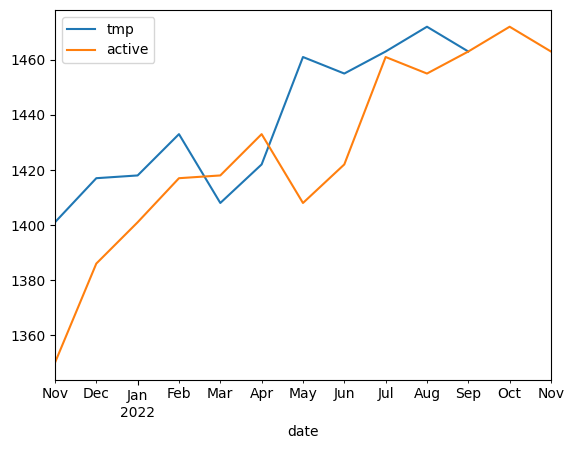

In [165]:
tmp = total_df[:13]
tmp['tmp'] = tmp['active'] - tmp['active'].diff(-2).values #/ tmp['active'].values
tmp[['tmp','active']].plot()

<AxesSubplot: xlabel='date'>

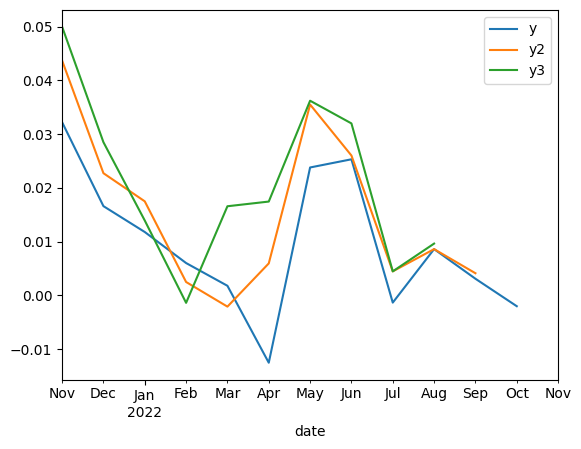

In [166]:
total_df[:13][['y','y2','y3']].plot()

In [167]:
total_df.columns

Index(['cfips', 'active', 'rent_50_1', 'DGS10', 'non_inst_pop', 'total_pop',
       'pct_non_inst_pop', 'employed', 'unemployed', 'year',
       ...
       'RSI6gdp__change2', 'ROC6gdp__change2', 'BBANDS2h_6gdp__change2',
       'BBANDS2l_6gdp__change2', 'EMA12gdp__change2', 'MOM12gdp__change2',
       'RSI12gdp__change2', 'ROC12gdp__change2', 'BBANDS2h_12gdp__change2',
       'BBANDS2l_12gdp__change2'],
      dtype='object', length=600)

In [168]:
total_df.columns.tolist()

['cfips',
 'active',
 'rent_50_1',
 'DGS10',
 'non_inst_pop',
 'total_pop',
 'pct_non_inst_pop',
 'employed',
 'unemployed',
 'year',
 'tax_rate',
 'tax_rate_diff',
 'population',
 'Total population',
 'Under 18 years',
 'Median age (years)',
 'Sex ratio (males per 100 females)',
 'Age dependency ratio',
 'Old-age dependency ratio',
 'Child dependency ratio',
 '18_ratio',
 'ESTIMATESBASE2020',
 'POPESTIMATE2020',
 'POPESTIMATE2021',
 'POPESTIMATE2022',
 'NPOPCHG_2020',
 'NPOPCHG_2021',
 'NPOPCHG_2022',
 'BIRTHS2020',
 'BIRTHS2021',
 'BIRTHS2022',
 'DEATHS2020',
 'DEATHS2021',
 'DEATHS2022',
 'NATURALCHG2020',
 'NATURALCHG2021',
 'NATURALCHG2022',
 'INTERNATIONALMIG2020',
 'INTERNATIONALMIG2021',
 'INTERNATIONALMIG2022',
 'DOMESTICMIG2020',
 'DOMESTICMIG2021',
 'DOMESTICMIG2022',
 'NETMIG2020',
 'NETMIG2021',
 'NETMIG2022',
 'RESIDUAL2020',
 'RESIDUAL2021',
 'RESIDUAL2022',
 'RBIRTH2021',
 'RBIRTH2022',
 'RDEATH2021',
 'RDEATH2022',
 'RNATURALCHG2021',
 'RNATURALCHG2022',
 'RINTERNATION

In [169]:
test_df = test_df.drop(['y'],axis=1)


In [170]:
total_df.columns[total_df.isna().any()].tolist()

['y',
 'y2',
 'y3',
 'y4',
 'y5',
 'macro10',
 'macro11',
 'S0101_C02_006E_change1',
 'S0101_C02_008E_change1',
 'macro10_change1',
 'macro11_change1',
 'ROC2active__change1',
 'MOM3active__change1',
 'RSI3active__change1',
 'ROC3active__change1',
 'MOM6active__change1',
 'RSI6active__change1',
 'ROC6active__change1',
 'MOM12active__change1',
 'RSI12active__change1',
 'ROC12active__change1',
 'S0101_C02_006E_change2',
 'S0101_C02_008E_change2',
 'macro10_change2',
 'macro11_change2',
 'ROC2active__change2',
 'MOM3active__change2',
 'RSI3active__change2',
 'ROC3active__change2',
 'MOM6active__change2',
 'RSI6active__change2',
 'ROC6active__change2',
 'MOM12active__change2',
 'RSI12active__change2',
 'ROC12active__change2']

In [171]:
feat = ['macro10',
 'macro11',
 'S0101_C02_006E_change1',
 'S0101_C02_008E_change1',
 'macro10_change1',
 'macro11_change1',
 'ROC2active__change1',
 'MOM3active__change1',
 'RSI3active__change1',
 'ROC3active__change1',
 'MOM6active__change1',
 'RSI6active__change1',
 'ROC6active__change1',
 'MOM12active__change1',
 'RSI12active__change1',
 'ROC12active__change1',
 'S0101_C02_006E_change2',
 'S0101_C02_008E_change2',
 'macro10_change2',
 'macro11_change2',
 'ROC2active__change2',
 'MOM3active__change2',
 'RSI3active__change2',
 'ROC3active__change2',
 'MOM6active__change2',
 'RSI6active__change2',
 'ROC6active__change2',
 'MOM12active__change2',
 'RSI12active__change2',
 'ROC12active__change2']

In [172]:
total_df = total_df.drop(feat,axis=1)

In [173]:
test_df = test_df.drop(feat,axis=1)

In [174]:
total_df = total_df.sort_values(['cfips', 'date'])

In [176]:
X_train = total_df.drop(['y2','y3','y4','y5'],axis=1).dropna()
time_index = X_train[:12].index
time_index

DatetimeIndex(['2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [177]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(max_train_size=4,test_size=2,n_splits=3)
era = time_index
for i, (train_index, test_index) in enumerate(tscv.split(era)):
    print(train_index, test_index)

[2 3 4 5] [6 7]
[4 5 6 7] [8 9]
[6 7 8 9] [10 11]


In [134]:
import optuna
import warnings
best_model = 0
pred_col = 'y'
if True:
       best_loss = 1000
       def objective(trial):   
              global  best_loss, best_model
              param = {}
              param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
              param['max_depth'] = trial.suggest_int('depth', 2, 5)
              param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
              param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
              param['grow_policy'] = 'Depthwise'
              param['iterations'] = 1000
              param['use_best_model'] = True
              param['loss_function'] = 'MAE'
              param['eval_metric'] = 'MAE'
              param['od_type'] = 'iter'
              param['od_wait'] = 20
              param['random_state'] = 927
              param['logging_level'] = 'Silent'
              param["bootstrap_type"] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

              if param["bootstrap_type"] == "Bayesian":
                     param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
              #elif param["bootstrap_type"] == "Bernoulli":
              #       param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

              smape_loss = 0
              ensemble_model = []
              
              for i, (train_index, test_index) in enumerate(tscv.split(era)):
                     #print(f"Fold {i}:")
                     train_idx = era[train_index]
                     test_idx = era[test_index]
                     train_x = X_train.loc[train_idx].drop([pred_col],axis=1)
                     train_y = X_train.loc[train_idx][pred_col]
                     test_x = X_train.loc[test_idx].drop([pred_col],axis=1)
                     test_y = X_train.loc[test_idx][pred_col]
                     model = CatBoostRegressor(**param)
                     model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100)
                     ensemble_model.append(model)
                     test_pred = model.predict(X_train.drop([pred_col],axis=1))

                     true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
                     pred = 100 * X_train['active'] * (1+ test_pred) / X_train['S0101_C01_026E']
                     smape_loss = smape(true, pred)

                     if smape_loss < best_loss:
                            best_loss = smape_loss
                            print(smape_loss)
                            best_model = model
              return smape_loss #/ (i+1)

       study = optuna.create_study(direction='minimize')
       optuna.logging.set_verbosity(optuna.logging.WARNING)
       warnings.filterwarnings("ignore")

       study.optimize(objective, n_trials=10) #, callbacks=[callback])

       optuna.visualization.plot_optimization_history(study)


1.3487235343353816
1.3170219392699567
1.3071175934630808
1.3007725114629511
1.2974869350592875
1.2973393265345694


In [135]:
study.best_params

{'learning_rate': 0.016,
 'depth': 2,
 'l2_leaf_reg': 1.0,
 'min_child_samples': 16,
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 4.23068284862102}

In [136]:
model = best_model
feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.drop([pred_col],axis=1).columns}).sort_values(by="Value",ascending=False)
feature_imp.head(30)

,Value,Feature
328,8.626032,RSI3house__change1
495,8.024026,BBANDS2l_3earn__change2
340,6.182483,RSI12house__change1
334,5.726627,RSI6house__change1
563,4.904805,BBANDS2h_12gdp__change2
377,4.446114,MOM12gdp__change1
123,3.595111,ROC2earn_
485,2.450295,RSI12DGS10__change2
379,2.344370,ROC12gdp__change1
330,2.273535,BBANDS2h_3house__change1


In [137]:

pred = 100 * np.round(X_train['active'] * (1)) / X_train['S0101_C01_026E']
true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
smape_loss = smape(true, pred)
print(smape_loss)


First = True

test_pred = model.predict(X_train.drop([pred_col],axis=1))
#true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
if First:
    pred = test_pred #100 * np.round(X_train['active'] * (1+ test_pred)) / X_train['S0101_C01_026E']
    First= False
else:
    pred += test_pred #100 * np.round(X_train['active'] * (1+ test_pred)) / X_train['S0101_C01_026E']
#smape_loss = smape(true, pred)
#print(smape_loss)
#pred /= 3
pred = 100 * np.round(X_train['active'] * (1+ pred)) / X_train['S0101_C01_026E']
true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
smape_loss = smape(true, pred)
print(smape_loss)

###########################
First = True

test_pred = model.predict(test_df)
#true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
if First:
    pred = test_pred #100 * np.round(test_df['active'] * (1+ test_pred)) / test_df['S0101_C01_026E']
    First= False
else:
    pred += test_pred #100 * np.round(test_df['active'] * (1+ test_pred)) / test_df['S0101_C01_026E']
#smape_loss = smape(true, pred)
#print(smape_loss)
#pred /= 3
pred = 100 * np.round(test_df['active'] * (1+ pred)) / test_df['S0101_C01_026E']
#true = 100 * np.round(test_df['active'] * (1+ test_df[pred_col])) / test_df['S0101_C01_026E']
#smape_loss = smape(true, pred)
print(pred)

1.3553230468886501
1.2849625727164133
date
2022-12-01     3.328233
2022-12-01     7.949805
2022-12-01     1.245311
2022-12-01     1.292135
2022-12-01     1.822969
                ...    
2022-12-01     2.935203
2022-12-01    26.448954
2022-12-01     4.036610
2022-12-01     3.100000
2022-12-01     1.836698
Length: 3131, dtype: float64


In [138]:
predd =  pd.DataFrame()
predd.index = test_df.sort_values('cfips')['cfips']
predd['pred'] = pred.values
predd

,pred
cfips,
1001,3.328233
1003,7.949805
1005,1.245311
1007,1.292135
1009,1.822969
...,...
56037,2.935203
56039,26.448954
56041,4.036610


In [234]:
X_train = total_df.drop(['y','y3','y4','y5'],axis=1)
X_train['S0101_C01_026E'] = X_train['S0101_C01_026E'].shift(-1)
X_train = X_train.dropna()
time_index = X_train[:11].index
time_index

DatetimeIndex(['2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [236]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(max_train_size=4,test_size=2,n_splits=3)
era = time_index
for i, (train_index, test_index) in enumerate(tscv.split(era)):
    print(train_index, test_index)

[1 2 3 4] [5 6]
[3 4 5 6] [7 8]
[5 6 7 8] [ 9 10]


In [237]:
import optuna
import warnings
best_model = []
pred_col = 'y2'
if True:
       best_loss = 1000
       def objective(trial):   
              global  best_loss, best_model
              param = {}
              param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
              param['max_depth'] = trial.suggest_int('depth', 2, 5)
              param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
              param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
              param['grow_policy'] = 'Depthwise'
              param['iterations'] = 1000
              param['use_best_model'] = True
              param['loss_function'] = 'MAE'
              param['eval_metric'] = 'MAE'
              param['od_type'] = 'iter'
              param['od_wait'] = 20
              param['random_state'] = 927
              param['logging_level'] = 'Silent'
              param["bootstrap_type"] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

              if param["bootstrap_type"] == "Bayesian":
                     param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
              #elif param["bootstrap_type"] == "Bernoulli":
              #       param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

              smape_loss = 0
              ensemble_model = []
              
              for i, (train_index, test_index) in enumerate(tscv.split(era)):
                     #print(f"Fold {i}:")
                     train_idx = era[train_index]
                     test_idx = era[test_index]
                     train_x = X_train.loc[train_idx].drop([pred_col],axis=1)
                     train_y = X_train.loc[train_idx][pred_col]
                     test_x = X_train.loc[test_idx].drop([pred_col],axis=1)
                     test_y = X_train.loc[test_idx][pred_col]
                     model = CatBoostRegressor(**param)
                     model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=50)
                     ensemble_model.append(model)
                     test_pred = model.predict(X_train.drop([pred_col],axis=1))

                     true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
                     pred = 100 * X_train['active'] * (1+ test_pred) / X_train['S0101_C01_026E']
                     smape_loss = smape(true, pred)

                     if smape_loss < best_loss:
                            best_loss = smape_loss
                            print(smape_loss)
                            best_model.append(model)
              return smape_loss #/ (i+1)

       study = optuna.create_study(direction='minimize')
       optuna.logging.set_verbosity(optuna.logging.WARNING)
       warnings.filterwarnings("ignore")

       study.optimize(objective, n_trials=10) #, callbacks=[callback])

       optuna.visualization.plot_optimization_history(study)


2.2222560609776707
2.0800498465915003


In [239]:

pred = 100 * np.round(X_train['active'] * (1)) / X_train['S0101_C01_026E']
true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
smape_loss = smape(true, pred)
print(smape_loss)

ensem = 1
First = True
for model in best_model[-ensem:]:
    test_pred = model.predict(X_train.drop([pred_col],axis=1))
    #true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
    if First:
        pred = test_pred #100 * np.round(X_train['active'] * (1+ test_pred)) / X_train['S0101_C01_026E']
        First= False
    else:
        pred += test_pred #100 * np.round(X_train['active'] * (1+ test_pred)) / X_train['S0101_C01_026E']
    #smape_loss = smape(true, pred)
    #print(smape_loss)
pred /= ensem
pred = 100 * np.round(X_train['active'] * (1+ pred)) / X_train['S0101_C01_026E']
true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
smape_loss = smape(true, pred)
print(smape_loss)

###########################
First = True
for model in best_model[-ensem:]:
    test_pred = model.predict(test_df)
    #true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
    if First:
        pred = test_pred #100 * np.round(test_df['active'] * (1+ test_pred)) / test_df['S0101_C01_026E']
        First= False
    else:
        pred += test_pred #100 * np.round(test_df['active'] * (1+ test_pred)) / test_df['S0101_C01_026E']
#smape_loss = smape(true, pred)
#print(smape_loss)
pred /= ensem
pred = 100 * np.round(test_df['active'] * (1+ pred)) / test_df['S0101_C01_026E']
#true = 100 * np.round(test_df['active'] * (1+ test_df[pred_col])) / test_df['S0101_C01_026E']
#smape_loss = smape(true, pred)
print(pred)

2.3148755082870256
2.074138490171451
date
2022-12-01     3.323732
2022-12-01     7.931276
2022-12-01     1.245311
2022-12-01     1.292135
2022-12-01     1.825181
                ...    
2022-12-01     2.922511
2022-12-01    26.381136
2022-12-01     4.022949
2022-12-01     3.083333
2022-12-01     1.836698
Length: 3131, dtype: float64


In [240]:
predd['pred2'] = pred.values
predd

,pred,pred2,pred3,pred4,pred5
cfips,,,,,
1001,3.328233,3.323732,3.361987,3.373239,3.397993
1003,7.949805,7.931276,7.987985,8.022796,8.032902
1005,1.245311,1.245311,1.260315,1.260315,1.270318
1007,1.292135,1.292135,1.308989,1.314607,1.308989
1009,1.822969,1.825181,1.847304,1.849517,1.853941
...,...,...,...,...,...
56037,2.935203,2.922511,2.957416,2.973282,2.963762
56039,26.448954,26.381136,26.516772,26.699358,26.532422
56041,4.036610,4.022949,4.050270,4.077590,4.077590


In [307]:
X_train = total_df.drop(['y','y2','y4','y5'],axis=1)
X_train['S0101_C01_026E'] = X_train['S0101_C01_026E'].shift(-2)
X_train = X_train.dropna()
time_index = X_train[:10].index
time_index

DatetimeIndex(['2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [327]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(max_train_size=4,test_size=1,n_splits=3)
era = time_index
for i, (train_index, test_index) in enumerate(tscv.split(era)):
    print(train_index, test_index)

[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [328]:
import optuna
import warnings
best_model = []
pred_col = 'y3'
if True:
       best_loss = 1000
       def objective(trial):   
              global  best_loss, best_model
              param = {}
              param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
              param['max_depth'] = trial.suggest_int('depth', 2, 5)
              param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
              param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
              param['grow_policy'] = 'Depthwise'
              param['iterations'] = 1000
              param['use_best_model'] = True
              param['loss_function'] = 'MAE'
              param['eval_metric'] = 'MAE'
              param['od_type'] = 'iter'
              param['od_wait'] = 20
              param['random_state'] = 927
              param['logging_level'] = 'Silent'
              param["bootstrap_type"] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

              if param["bootstrap_type"] == "Bayesian":
                     param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
              #elif param["bootstrap_type"] == "Bernoulli":
              #       param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

              smape_loss = 0
              ensemble_model = []
              
              for i, (train_index, test_index) in enumerate(tscv.split(era)):
                     #print(f"Fold {i}:")
                     train_idx = era[train_index]
                     test_idx = era[test_index]
                     train_x = X_train.loc[train_idx].drop([pred_col],axis=1)
                     train_y = X_train.loc[train_idx][pred_col]
                     test_x = X_train.loc[test_idx].drop([pred_col],axis=1)
                     test_y = X_train.loc[test_idx][pred_col]
                     model = CatBoostRegressor(**param)
                     model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=50)
                     ensemble_model.append(model)
                     test_pred = model.predict(X_train.drop([pred_col],axis=1))

                     true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
                     pred = 100 * X_train['active'] * (1+ test_pred) / X_train['S0101_C01_026E']
                     smape_loss = smape(true, pred)

                     if smape_loss < best_loss:
                            best_loss = smape_loss
                            print(smape_loss)
                            best_model.append(model)
              return smape_loss #/ (i+1)

       study = optuna.create_study(direction='minimize')
       optuna.logging.set_verbosity(optuna.logging.WARNING)
       warnings.filterwarnings("ignore")

       study.optimize(objective, n_trials=20) #, callbacks=[callback])

       optuna.visualization.plot_optimization_history(study)


2.7101042938909705
2.6893903411286213
2.6463541014931673
2.5692974744488337


In [330]:

pred = 100 * np.round(X_train['active'] * (1)) / X_train['S0101_C01_026E']
true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
smape_loss = smape(true, pred)
print(smape_loss)

ensem = 1
First = True
for model in best_model[-ensem:]:
    test_pred = model.predict(X_train.drop([pred_col],axis=1))
    #true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
    if First:
        pred = test_pred #100 * np.round(X_train['active'] * (1+ test_pred)) / X_train['S0101_C01_026E']
        First= False
    else:
        pred += test_pred #100 * np.round(X_train['active'] * (1+ test_pred)) / X_train['S0101_C01_026E']
    #smape_loss = smape(true, pred)
    #print(smape_loss)
pred /= ensem
pred = 100 * np.round(X_train['active'] * (1+ pred)) / X_train['S0101_C01_026E']
true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
smape_loss = smape(true, pred)
print(smape_loss)

###########################
First = True
for model in best_model[-ensem:]:
    test_pred = model.predict(test_df)
    #true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
    if First:
        pred = test_pred #100 * np.round(test_df['active'] * (1+ test_pred)) / test_df['S0101_C01_026E']
        First= False
    else:
        pred += test_pred #100 * np.round(test_df['active'] * (1+ test_pred)) / test_df['S0101_C01_026E']
#smape_loss = smape(true, pred)
#print(smape_loss)
pred /= ensem
pred = 100 * np.round(test_df['active'] * (1+ pred)) / test_df['S0101_C01_026E']
#true = 100 * np.round(test_df['active'] * (1+ test_df[pred_col])) / test_df['S0101_C01_026E']
#smape_loss = smape(true, pred)
print(pred)

2.952758775181161
2.562637358867837
date
2022-12-01     3.368738
2022-12-01     8.014935
2022-12-01     1.260315
2022-12-01     1.308989
2022-12-01     1.847304
                ...    
2022-12-01     2.954243
2022-12-01    26.668058
2022-12-01     4.057100
2022-12-01     3.116667
2022-12-01     1.836698
Length: 3131, dtype: float64


In [331]:
predd['pred3'] = pred.values
predd

,pred,pred2,pred3,pred4,pred5
cfips,,,,,
1001,3.328233,3.323732,3.368738,3.373239,3.397993
1003,7.949805,7.931276,8.014935,8.022796,8.032902
1005,1.245311,1.245311,1.260315,1.260315,1.270318
1007,1.292135,1.292135,1.308989,1.314607,1.308989
1009,1.822969,1.825181,1.847304,1.849517,1.853941
...,...,...,...,...,...
56037,2.935203,2.922511,2.954243,2.973282,2.963762
56039,26.448954,26.381136,26.668058,26.699358,26.532422
56041,4.036610,4.022949,4.057100,4.077590,4.077590


In [343]:
X_train = total_df.drop(['y','y2','y3','y5'],axis=1)
X_train['S0101_C01_026E'] = X_train['S0101_C01_026E'].shift(-3)
X_train = X_train.dropna()

time_index = X_train[:9].index
time_index

DatetimeIndex(['2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [344]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(max_train_size=4,test_size=1,n_splits=3)
era = time_index
for i, (train_index, test_index) in enumerate(tscv.split(era)):
    print(train_index, test_index)

[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]


In [345]:
import optuna
import warnings
best_model = []
pred_col = 'y4'
if True:
       best_loss = 1000
       def objective(trial):   
              global  best_loss, best_model
              param = {}
              param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
              param['max_depth'] = trial.suggest_int('depth', 2, 5)
              param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
              param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
              param['grow_policy'] = 'Depthwise'
              param['iterations'] = 1000
              param['use_best_model'] = True
              param['loss_function'] = 'MAE'
              param['eval_metric'] = 'MAE'
              param['od_type'] = 'iter'
              param['od_wait'] = 20
              param['random_state'] = 927
              param['logging_level'] = 'Silent'
              param["bootstrap_type"] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

              if param["bootstrap_type"] == "Bayesian":
                     param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
              #elif param["bootstrap_type"] == "Bernoulli":
              #       param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

              smape_loss = 0
              ensemble_model = []
              
              for i, (train_index, test_index) in enumerate(tscv.split(era)):
                     #print(f"Fold {i}:")
                     train_idx = era[train_index]
                     test_idx = era[test_index]
                     train_x = X_train.loc[train_idx].drop([pred_col],axis=1)
                     train_y = X_train.loc[train_idx][pred_col]
                     test_x = X_train.loc[test_idx].drop([pred_col],axis=1)
                     test_y = X_train.loc[test_idx][pred_col]
                     model = CatBoostRegressor(**param)
                     model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=50)
                     ensemble_model.append(model)
                     test_pred = model.predict(X_train.drop([pred_col],axis=1))

                     true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
                     pred = 100 * X_train['active'] * (1+ test_pred) / X_train['S0101_C01_026E']
                     smape_loss = smape(true, pred)

                     if smape_loss < best_loss:
                            best_loss = smape_loss
                            print(smape_loss)
                            best_model.append(model)
              return smape_loss #/ (i+1)

       study = optuna.create_study(direction='minimize')
       optuna.logging.set_verbosity(optuna.logging.WARNING)
       warnings.filterwarnings("ignore")

       study.optimize(objective, n_trials=20) #, callbacks=[callback])

       optuna.visualization.plot_optimization_history(study)


3.184528647522969
3.0636212528428457
3.0508536568083557
3.017155651798251


In [346]:

pred = 100 * np.round(X_train['active'] * (1)) / X_train['S0101_C01_026E']
true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
smape_loss = smape(true, pred)
print(smape_loss)

ensem = 2
First = True
for model in best_model[-ensem:]:
    test_pred = model.predict(X_train.drop([pred_col],axis=1))
    #true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
    if First:
        pred = test_pred #100 * np.round(X_train['active'] * (1+ test_pred)) / X_train['S0101_C01_026E']
        First= False
    else:
        pred += test_pred #100 * np.round(X_train['active'] * (1+ test_pred)) / X_train['S0101_C01_026E']
    #smape_loss = smape(true, pred)
    #print(smape_loss)
pred /= ensem
pred = 100 * np.round(X_train['active'] * (1+ pred)) / X_train['S0101_C01_026E']
true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
smape_loss = smape(true, pred)
print(smape_loss)

###########################
First = True
for model in best_model[-ensem:]:
    test_pred = model.predict(test_df)
    #true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
    if First:
        pred = test_pred #100 * np.round(test_df['active'] * (1+ test_pred)) / test_df['S0101_C01_026E']
        First= False
    else:
        pred += test_pred #100 * np.round(test_df['active'] * (1+ test_pred)) / test_df['S0101_C01_026E']
#smape_loss = smape(true, pred)
#print(smape_loss)
pred /= ensem
pred = 100 * np.round(test_df['active'] * (1+ pred)) / test_df['S0101_C01_026E']
#true = 100 * np.round(test_df['active'] * (1+ test_df[pred_col])) / test_df['S0101_C01_026E']
#smape_loss = smape(true, pred)
print(pred)

3.5396768611785134
3.028238916770614
date
2022-12-01     3.373239
2022-12-01     8.004829
2022-12-01     1.265316
2022-12-01     1.308989
2022-12-01     1.847304
                ...    
2022-12-01     2.966935
2022-12-01    26.615890
2022-12-01     4.063930
2022-12-01     3.116667
2022-12-01     1.854883
Length: 3131, dtype: float64


In [216]:
predd['pred4'] = pred.values
predd

,pred,pred2,pred3,pred4
cfips,,,,
1001,3.328233,3.328233,3.361987,3.373239
1003,7.949805,7.934084,7.987985,8.022796
1005,1.245311,1.245311,1.260315,1.260315
1007,1.292135,1.292135,1.308989,1.314607
1009,1.822969,1.831818,1.847304,1.849517
...,...,...,...,...
56037,2.935203,2.928857,2.957416,2.973282
56039,26.448954,26.391570,26.516772,26.699358
56041,4.036610,4.022949,4.050270,4.077590


In [332]:
X_train = total_df.drop(['y','y2','y3','y4'],axis=1)

X_train['S0101_C01_026E'] = X_train['S0101_C01_026E'].shift(-3)
X_train = X_train.dropna()

time_index = X_train[:8].index
time_index

DatetimeIndex(['2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [333]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(max_train_size=3,test_size=1,n_splits=3)
era = time_index
for i, (train_index, test_index) in enumerate(tscv.split(era)):
    print(train_index, test_index)

[2 3 4] [5]
[3 4 5] [6]
[4 5 6] [7]


In [335]:
import optuna
import warnings
best_model = []
pred_col = 'y5'
if True:
       best_loss = 1000
       def objective(trial):   
              global  best_loss, best_model
              param = {}
              param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
              param['max_depth'] = trial.suggest_int('depth', 2, 5)
              param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
              param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
              param['grow_policy'] = 'Depthwise'
              param['iterations'] = 1000
              param['use_best_model'] = True
              param['loss_function'] = 'MAE'
              param['eval_metric'] = 'MAE'
              param['od_type'] = 'iter'
              param['od_wait'] = 20
              param['random_state'] = 927
              param['logging_level'] = 'Silent'
              param["bootstrap_type"] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

              if param["bootstrap_type"] == "Bayesian":
                     param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
              #elif param["bootstrap_type"] == "Bernoulli":
              #       param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

              smape_loss = 0
              ensemble_model = []
              
              for i, (train_index, test_index) in enumerate(tscv.split(era)):
                     #print(f"Fold {i}:")
                     train_idx = era[train_index]
                     test_idx = era[test_index]
                     train_x = X_train.loc[train_idx].drop([pred_col],axis=1)
                     train_y = X_train.loc[train_idx][pred_col]
                     test_x = X_train.loc[test_idx].drop([pred_col],axis=1)
                     test_y = X_train.loc[test_idx][pred_col]
                     model = CatBoostRegressor(**param)
                     model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=50)
                     ensemble_model.append(model)
                     test_pred = model.predict(X_train.drop([pred_col],axis=1))

                     true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
                     pred = 100 * X_train['active'] * (1+ test_pred) / X_train['S0101_C01_026E']
                     smape_loss = smape(true, pred)

                     if smape_loss < best_loss:
                            best_loss = smape_loss
                            print(smape_loss)
                            best_model.append(model)
              return smape_loss #/ (i+1)

       study = optuna.create_study(direction='minimize')
       optuna.logging.set_verbosity(optuna.logging.WARNING)
       warnings.filterwarnings("ignore")

       study.optimize(objective, n_trials=30) #, callbacks=[callback])

       optuna.visualization.plot_optimization_history(study)


3.543363165616728
3.5424683850802308
3.538285059489265
3.41231698304015
3.322892472357488
3.2734472848029097


In [340]:

pred = 100 * np.round(X_train['active'] * (1)) / X_train['S0101_C01_026E']
true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
smape_loss = smape(true, pred)
print(smape_loss)

ensem = 2
First = True
for model in best_model[-ensem:]:
    test_pred = model.predict(X_train.drop([pred_col],axis=1))
    #true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
    if First:
        pred = test_pred #100 * np.round(X_train['active'] * (1+ test_pred)) / X_train['S0101_C01_026E']
        First= False
    else:
        pred += test_pred #100 * np.round(X_train['active'] * (1+ test_pred)) / X_train['S0101_C01_026E']
    #smape_loss = smape(true, pred)
    #print(smape_loss)
pred /= ensem
pred = 100 * np.round(X_train['active'] * (1+ pred)) / X_train['S0101_C01_026E']
true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
smape_loss = smape(true, pred)
print(smape_loss)

###########################
First = True
for model in best_model[-ensem:]:
    test_pred = model.predict(test_df)
    #true = 100 * np.round(X_train['active'] * (1+ X_train[pred_col])) / X_train['S0101_C01_026E']
    if First:
        pred = test_pred #100 * np.round(test_df['active'] * (1+ test_pred)) / test_df['S0101_C01_026E']
        First= False
    else:
        pred += test_pred #100 * np.round(test_df['active'] * (1+ test_pred)) / test_df['S0101_C01_026E']
#smape_loss = smape(true, pred)
#print(smape_loss)
pred /= ensem
pred = 100 * np.round(test_df['active'] * (1+ pred)) / test_df['S0101_C01_026E']
#true = 100 * np.round(test_df['active'] * (1+ test_df[pred_col])) / test_df['S0101_C01_026E']
#smape_loss = smape(true, pred)
print(pred)

4.127026893438607
3.291624494387201
date
2022-12-01     3.393492
2022-12-01     8.016058
2022-12-01     1.265316
2022-12-01     1.320225
2022-12-01     1.856154
                ...    
2022-12-01     2.976455
2022-12-01    26.673275
2022-12-01     4.084420
2022-12-01     3.150000
2022-12-01     1.854883
Length: 3131, dtype: float64


In [341]:
predd['pred5'] = pred.values
predd

,pred,pred2,pred3,pred4,pred5
cfips,,,,,
1001,3.328233,3.323732,3.368738,3.373239,3.393492
1003,7.949805,7.931276,8.014935,8.022796,8.016058
1005,1.245311,1.245311,1.260315,1.260315,1.265316
1007,1.292135,1.292135,1.308989,1.314607,1.320225
1009,1.822969,1.825181,1.847304,1.849517,1.856154
...,...,...,...,...,...
56037,2.935203,2.922511,2.954243,2.973282,2.976455
56039,26.448954,26.381136,26.668058,26.699358,26.673275
56041,4.036610,4.022949,4.057100,4.077590,4.084420


In [255]:
predd

,pred,pred2,pred3,pred4,pred5
cfips,,,,,
1001,3.328233,3.323732,3.361987,3.373239,3.397993
1003,7.949805,7.931276,7.987985,8.022796,8.032902
1005,1.245311,1.245311,1.260315,1.260315,1.270318
1007,1.292135,1.292135,1.308989,1.314607,1.308989
1009,1.822969,1.825181,1.847304,1.849517,1.853941
...,...,...,...,...,...
56037,2.935203,2.922511,2.957416,2.973282,2.963762
56039,26.448954,26.381136,26.516772,26.699358,26.532422
56041,4.036610,4.022949,4.050270,4.077590,4.077590


In [347]:
baseline = pd.read_csv('1.3724.csv')

In [348]:
reveal = pd.read_csv('revealed_test.csv')
reveal = reveal.query('first_day_of_month=="2022-12-01"').sort_values('cfips')

In [349]:
#month_13 = final_pred

all_month =  pd.DataFrame()
all_month.index = reveal['cfips']
all_month['pred'] = reveal['microbusiness_density'].values
all_month['pred2'] = all_month['pred'] 

all_month['pred3'] = baseline[2::8]['microbusiness_density'].values
#all_month['pred3'].update(predd['pred'])

#all_month.loc[28055] = [0.094607, 0.094607,0.094607]
#all_month.loc[48301] = [1.098901, 1.098901	, 1.098901	]	
#all_month.loc[48269] = [2.202643, 2.202643	, 2.202643	]	

In [350]:
all_month = all_month.sort_index()

In [351]:
all_month

,pred,pred2,pred3
cfips,,,
1001,3.470915,3.470915,3.337234
1003,8.250630,8.250630,7.962157
1005,1.252272,1.252272,1.245311
1007,1.287240,1.287240,1.292135
1009,1.852060,1.852060,1.827393
...,...,...,...
56037,2.876845,2.876845,2.938377
56039,26.314966,26.314966,26.428087
56041,4.050703,4.050703,4.036610


In [352]:
all_month['pred3a'] = all_month['pred3']
all_month['pred4'] = all_month['pred3']
all_month['pred5'] = all_month['pred3']
all_month['pred6'] = all_month['pred3']
all_month['pred7'] = all_month['pred3']

In [353]:
all_month['pred3a'].update(predd['pred2'])
all_month['pred4'].update(predd['pred3'])
all_month['pred5'].update(predd['pred4'])
all_month['pred6'].update(predd['pred5'])
all_month['pred7'].update(predd['pred5'])

In [354]:
all_month['pred3'] - baseline[2::8]['microbusiness_density'].values

cfips
1001     0.0
1003     0.0
1005     0.0
1007     0.0
1009     0.0
        ... 
56037    0.0
56039    0.0
56041    0.0
56043    0.0
56045    0.0
Name: pred3, Length: 3135, dtype: float64

In [355]:
test['microbusiness_density'] = all_month.values.reshape(-1)

In [356]:
test.head(10)

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.470915
1,1001_2022-12-01,1001,2022-12-01,3.470915
2,1001_2023-01-01,1001,2023-01-01,3.337234
3,1001_2023-02-01,1001,2023-02-01,3.323732
4,1001_2023-03-01,1001,2023-03-01,3.368738
5,1001_2023-04-01,1001,2023-04-01,3.373239
6,1001_2023-05-01,1001,2023-05-01,3.393492
7,1001_2023-06-01,1001,2023-06-01,3.393492
8,1003_2022-11-01,1003,2022-11-01,8.250630
9,1003_2022-12-01,1003,2022-12-01,8.250630


In [357]:
import pickle
save = True
if save:

    sub = test[['row_id','microbusiness_density']]
    sub.to_csv('submission.csv',index=False)
